# GRU Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("scripts")
from scripts.steam_review_dataset import SteamReviewDataset

In [3]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
# Lade die Daten
df = pd.read_csv("../data/reviews_100k.csv.bz2")

# Aufteilen in Train+Validation und Test (80/20 Split)
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["voted_up"])

# Aufteilen von Train+Validation in Training und Validation (75/25 von Train+Val)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df["voted_up"])

# Überprüfe die Größe der Splits
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 56742
Validation size: 18914
Test size: 18915


In [6]:
# Erstelle Dataset-Objekte
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
max_len = 200

train_dataset = SteamReviewDataset(data=train_df, tokenizer=tokenizer, max_len=max_len)
val_dataset = SteamReviewDataset(data=val_df, tokenizer=tokenizer, max_len=max_len)
test_dataset = SteamReviewDataset(data=test_df, tokenizer=tokenizer, max_len=max_len)

# Erstelle DataLoader für jeden Split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Batch Shape
for tokens, labels in train_loader:
    print(f"Tokens shape: {tokens.shape}, Labels shape: {labels.shape}")
    break

print(train_dataset[0])


Tokens shape: torch.Size([32, 200]), Labels shape: torch.Size([32])
(tensor([ 620,   65,    4,   84,  272,   22,  121,   39,    8,  256,  300,  342,
           5,  345,  701,  170,   63,    6,   38,   11,  163,   91,   11,  123,
           4,  373,   92,    9,  162,   39,  815,   92,  111,  111,  579,  441,
          12,    4,   17,    9,  274,   98, 1048,   18,   58,  147,  135,  397,
         131,  249,  244,   10,  129,    8,   55,  190,  552, 1108,  169,    7,
           4,  470, 1875,  168, 1415,   98,    8, 2720,  813, 2208,   23,   16,
          20,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [7]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, seq_length)
        
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        _, hidden = self.gru(embedded)  # hidden: (1, batch_size, hidden_dim)

        output = self.fc(hidden.squeeze(0))  # (batch_size, output_dim)

        output = self.sigmoid(output)
        return output

In [8]:
# Lade den Tokenizer, um `vocab_size` und `pad_id` zu erhalten
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
vocab_size = tokenizer.get_piece_size()
pad_idx = tokenizer.pad_id()

# Modellparameter
embedding_dim = 128
hidden_dim = 256
output_dim = 1

# Initialisiere das GRU-Modell
model = GRUClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx)
print(model)

GRUClassifier(
  (embedding): Embedding(8001, 128, padding_idx=0)
  (gru): GRU(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [9]:
def train_model(model:GRUClassifier, train_loader:DataLoader, val_loader:DataLoader, epochs:int, lr=0.001, device=torch.device("cpu")):
    # Loss und Optimizer definieren
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    print(f"Start training on device '{device}'")

    # Listen für Visualisierung
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training und Validation Loop
    for epoch in range(epochs):
        model.train()  # Setze das Modell in den Training-Modus
        running_loss = 0.0
        train_labels = []
        train_preds = []

        train_progress = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", ncols=100)

        epoch_start_time = time.time()  # Startzeit für die Epoche

        # Trainingsloop
        for batch in train_progress:
            tokens, labels = batch
            tokens, labels = tokens.to(device), labels.to(device)

            # Forward Pass
            optimizer.zero_grad()
            outputs = model(tokens)
            loss = criterion(outputs.squeeze(), labels)

            # Backward Pass und Optimierung
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Berechne Vorhersagen und füge sie zur Liste hinzu
            train_preds += (outputs.squeeze() > 0.5).cpu().numpy().tolist()
            train_labels += labels.cpu().numpy().tolist()

            # Update TQDM mit dem aktuellen Loss
            train_progress.set_postfix(loss=f"{running_loss / (train_progress.n + 1):.3f}")

        # Berechne Training Accuracy
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        # Validierung
        model.eval()  # Setze das Modell in den Eval-Modus
        val_loss = 0.0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for batch in val_loader:
                tokens, labels = batch
                tokens, labels = tokens.to(device), labels.to(device)

                outputs = model(tokens)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                val_preds += (outputs.squeeze() > 0.5).cpu().numpy().tolist()
                val_labels += labels.cpu().numpy().tolist()

        # Berechne Validierungs-Accuracy
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        mins, secs = divmod(epoch_duration, 60)
        
        # Ausgabe der Fortschritte mit TQDM
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, "
              f"Time: {mins}m {secs:.2f}s")
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [10]:
# Trainiere das Modell
epochs = 5
trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, epochs=epochs, lr=0.001, device=device)

Start training on device 'cuda'


Epoch [1/5]: 100%|██████████████████████████████████| 1774/1774 [00:22<00:00, 79.87it/s, loss=0.578]


Epoch [1/5], Train Loss: 0.5768, Train Accuracy: 0.7148, Validation Loss: 0.5167, Validation Accuracy: 0.8428, Time: 0.0m 26.54s


Epoch [2/5]: 100%|██████████████████████████████████| 1774/1774 [00:21<00:00, 80.75it/s, loss=0.508]


Epoch [2/5], Train Loss: 0.5071, Train Accuracy: 0.8450, Validation Loss: 0.4990, Validation Accuracy: 0.8731, Time: 0.0m 26.35s


Epoch [3/5]: 100%|██████████████████████████████████| 1774/1774 [00:22<00:00, 80.16it/s, loss=0.494]


Epoch [3/5], Train Loss: 0.4935, Train Accuracy: 0.8746, Validation Loss: 0.4921, Validation Accuracy: 0.8652, Time: 0.0m 26.50s


Epoch [4/5]: 100%|██████████████████████████████████| 1774/1774 [00:22<00:00, 80.47it/s, loss=0.491]


Epoch [4/5], Train Loss: 0.4901, Train Accuracy: 0.8804, Validation Loss: 0.5026, Validation Accuracy: 0.8378, Time: 0.0m 26.51s


Epoch [5/5]: 100%|██████████████████████████████████| 1774/1774 [00:22<00:00, 80.24it/s, loss=0.484]


Epoch [5/5], Train Loss: 0.4833, Train Accuracy: 0.8958, Validation Loss: 0.4981, Validation Accuracy: 0.8440, Time: 0.0m 26.50s


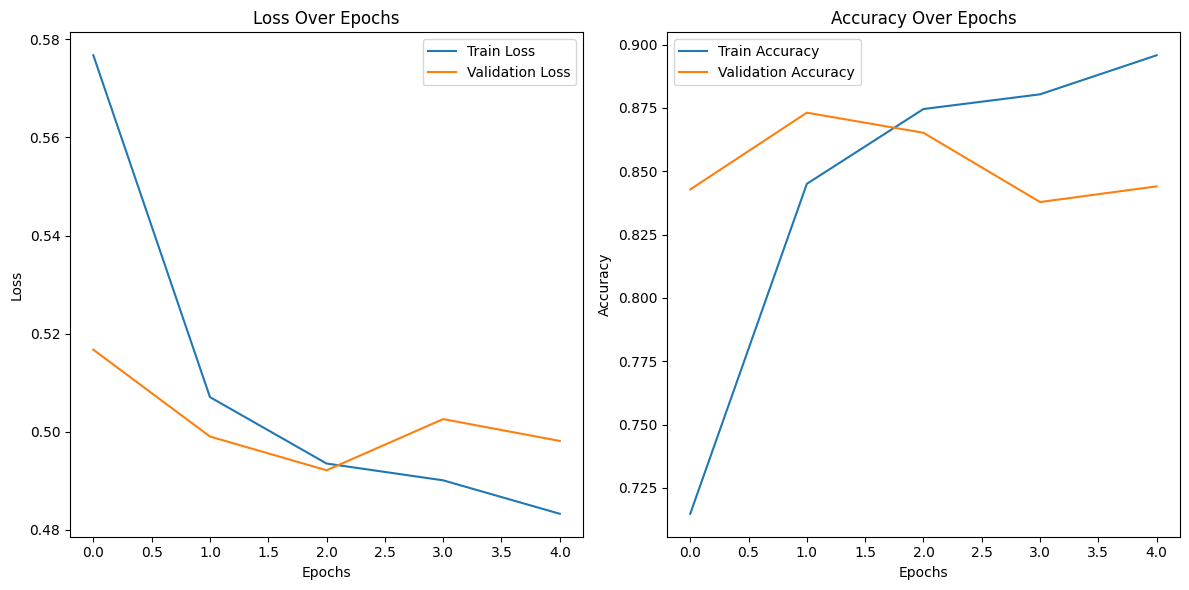

In [11]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    # Loss Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Anzeigen
    plt.tight_layout()
    plt.show()

plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [12]:
# Funktion zum Testen des Modells mit zusätzlichen Metriken
def evaluate_model(model, test_loader):
    model.eval()  # Setze das Modell in den Eval-Modus
    test_loss = 0.0
    test_labels = []
    test_preds = []

    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():  # Keine Gradientenberechnung für Test
        for batch in test_loader:
            tokens, labels = batch
            tokens, labels = tokens.to(device), labels.to(device)

            # Forward Pass
            outputs = model(tokens)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            # Berechne Vorhersagen und füge sie zur Liste hinzu
            test_preds += (outputs.squeeze() > 0.5).cpu().numpy().tolist()
            test_labels += labels.cpu().numpy().tolist()

    # Berechne Metriken
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds)
    test_recall = recall_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)

    # Ausgabe der Metriken
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

# Teste das Modell
evaluate_model(model, test_loader)

Test Loss: 0.4967
Test Accuracy: 0.8486
Test Precision: 0.9602
Test Recall: 0.8117
Test F1-Score: 0.8797


### Results

**Hardware Specs:**
- CPU: AMD Ryzen 7 3700X 8-Core
- GPU: Nvidia GeForce RTX 3060 Ti
- RAM: 47GB
- OS: Linux Mint 22.1

**Trainings Zeiten**

| Device | Epochen | LR    | Trainingszeit | Zeit pro Epoche | Acc     | F1      |
|--------|---------|-------|---------------|-----------------|---------|---------|
| CPU    | 5       | 0.001 | 00:18:24      | 03:41           | ?       | ?       |
| Cuda   | 5       | 0.001 | 00:02:13      | 00:27           | 0.8486  | 0.8797  |